# ADS-B RF Demodulation

**Author**: Brandon Liston

**Last Updated Date**: 01/08/2026

**Description**:  
This notebook is purposed to walkthrough a non-real-time demodulation of sampled  
[Automatic Dependent Surveillance-Broadcast](https://www.adsbexchange.com/) (ADS-B) RF I/Q data using a relatively  
lower bandwidth and lower bit-depth [RTL-SDR](https://www.rtl-sdr.com/). The focus will be on demodulating  
the RF Pulse Position Modulated (PPM) signal, and we'll use external http calls  
to decode the actual bit sequenced message.

ADS-B is a specific "broadcast" message sent by air traffic transponders that's  
required by the FAA in the U.S. for most aircrafts in controlled airspaces. Data  
information included in the broadcast message includes GPS positioning, altitude,  
speed, and aircraft identification numbers. If correctly demodulated, we should  
be able to recover this data packet information.

**References**:  
https://blog.exploit.org/ads-b-guide-demodulation-and-decoding/   
https://www.rtl-sdr.com/adsb-aircraft-radar-with-rtl-sdr/  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

ADS-B RF transmissions are encoded by a simple Pulse Position Modulated (PPM)  
digital modulation scheme. PPM is acts as a constant amplitude and time based RF  
modulation scheme, which bits are encoded by whether the amplitude of the signal  
at the configured RF was high or not is specified time slots.

ADS-B bit periods are `0.5` microseconds, and actual data is encoded through the  
use of 2 PPM bits. Data bits of `1` are encoded as `[1,0]` and `0` as `[0,1]`. To  
successfully decode demodulate the data, we need to sample at atleast `1/0.5`  
microseconds or `2.0` MSps.

### Visualizing ADS-B PPM Modulation

Let's create a synthetic encoding of an ADS-B modulated signal for a few  
different RF sampling rates using an I/Q representation of the RF signal.

In [2]:
num_adsb_bits: int = 16
random_adsb_data = np.random.randint(0, 2, size = num_adsb_bits)
random_adsb_data

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1])

In [18]:
ADSB_ZEROS_SEQ: list[int] = [0, 1]
ADSB_ONES_SEQ: list[int] = [1, 0]

def adsb_to_bits(adsb_bits: np.ndarray) -> np.ndarray:
    bits = []
    for adsb_bit in adsb_bits:
        if adsb_bit == 0: bits.extend(ADSB_ZEROS_SEQ)
        elif adsb_bit == 1: bits.extend(ADSB_ONES_SEQ)
        else: raise ValueError("ADS-B bits must be in the set {0, 1}.")
    
    return np.array(bits)

In [19]:
random_data = adsb_to_bits(random_adsb_data)
print(f"Number Data Bits: {random_data.size}")
random_data

Number Data Bits: 32


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0])

Now we can visualize the modulated data across several sample rates.

In [5]:
bit_data_period_sec: float = 0.5e-6

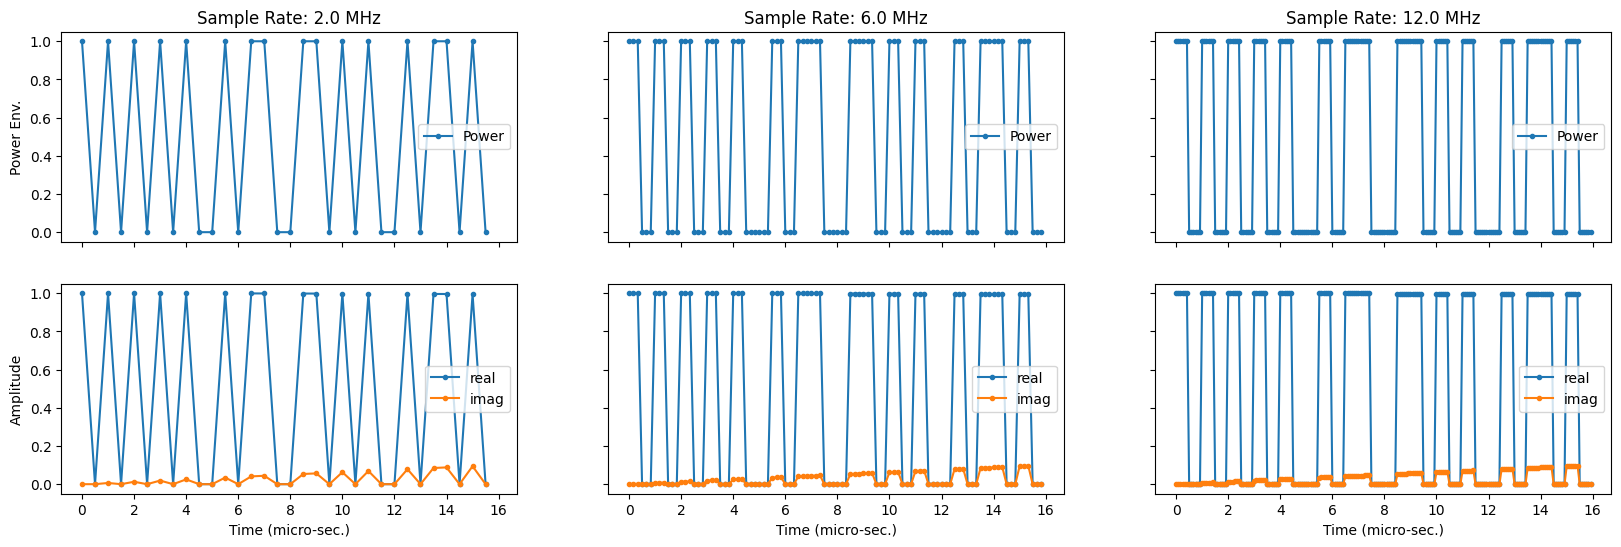

In [6]:
# A small frequency offset factor is applied to account for possible hardware 
# tuning imperfections that would cause the signal to not be DC in baseband IQ.
freq_hz: float = 1.0e3

bit_tx_duration_sec = len(random_data) * bit_data_period_sec
sample_rates_hz: list[float] = [2.0e6, 6.0e6, 12.0e6]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_size_inches(20.0, 6.0)
for sidx, sample_rate_hz in enumerate(sample_rates_hz):
    sampling_period_sec = 1.0 / sample_rate_hz
    time_sec = np.arange(0.0, bit_tx_duration_sec, step=sampling_period_sec)
    signal = np.exp(1j * 2 * np.pi * freq_hz * time_sec)
    
    up_sample_factor = signal.size // random_data.size
    up_sampled_data = np.repeat(random_data, up_sample_factor)
    
    signal *= up_sampled_data
    
    axes[0][sidx].plot(time_sec * 1e6, np.abs(signal)**2.0, marker="o", ms=3.0, label="Power")
    axes[1][sidx].plot(time_sec * 1e6, signal.real, marker="o", ms=3.0, label="real")
    axes[1][sidx].plot(time_sec * 1e6, signal.imag, marker="o", ms=3.0, label="imag")
    
    axes[0][sidx].legend()
    axes[1][sidx].legend()

    axes[0][sidx].set_title(f"Sample Rate: {sample_rate_hz/1e6} MHz")
    axes[1][sidx].set_xlabel("Time (micro-sec.)")
    if sidx == 0:
        axes[0][sidx].set_ylabel("Power Env.")
        axes[1][sidx].set_ylabel("Amplitude")
    

Note how obviously within the same timespan, higher sample rates will result in  
larger sets of values. This can be increasingly important given how our receiver  
has no way to synchorize a-prior to the timing of the transponder, which may  
result in receiving during transition periods of each of the pulses.

### Demodulating Collected ADS-B IQ

Next we'll attempt to demodulate a real data collection snippet of IQ at the  
_1090 MHz_ ADS-B band. The IQ was sampled at `2.0` MHz or `2.0` MSps, which is  
the lowest limit we can sample at and still attempt recover the ADS-B packet.

Additionally, the IQ snippet recorded, was done using `uint8` precision in an  
interleaved format. We'll imeddiately load and cast the signal to a complex  
float format.

In [7]:
def load_signal(path: Path, dtype=np.uint8) -> np.ndarray:
    data = np.fromfile(path, dtype=dtype)
    
    signed_data = data.astype(np.float32)
    signed_data -= 128.0
    signed_data /= 128.0
    
    return signed_data[::2] + 1j * signed_data[1::2]

In [8]:
sample_rate_hz: float = 2.0e6
data_path = Path("data/adsb_sample_10sec.dat")

In [9]:
signal = load_signal(data_path)
print(f"Number Recorded Complex Samples: {signal.size / 1e6} M")
print(f"Duration of Recording: {signal.size / sample_rate_hz} sec.")
print(f"Signal Data Type: {signal.dtype}")

Number Recorded Complex Samples: 20.0 M
Duration of Recording: 10.0 sec.
Signal Data Type: complex64


In [10]:
signal_power = np.abs(signal) ** 2.0

Text(0, 0.5, 'Power')

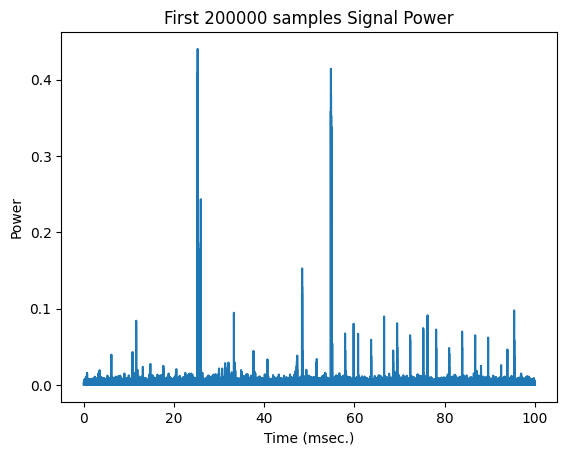

In [11]:
# We'll visualize a smaller snippet than the full duratio of the recorded IQ 
# signal.
num_plot_samples: int = 200_000

time_sec = np.arange(num_plot_samples) / sample_rate_hz
plt.title(f"First {num_plot_samples} samples Signal Power")
plt.plot(time_sec * 1e3, signal_power[:num_plot_samples])
plt.xlabel("Time (msec.)")
plt.ylabel("Power")

Next to find actual transmissions, we'll need to look for `preamble`'s of ADS-B  
transmissions. Lucky enough, the preamble is a constant bit sequence. 

It would be more robust to correlate our preamble against our loaded `signal`,  
but this would be computationally expensive. Rather, we'll set an initial  
threshold for our pulse detections and look for exact preamble matches.

In [12]:
# ADS-B preamble is 8 ADS-B symbols long, or 16 2-bit PPM encodings.
ppm_preamble = np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
print(f"Preamble Size: {ppm_preamble.size}")

Preamble Size: 16


In [13]:
power_threshold: float = 0.2

In [14]:
def find_adsb_packet_starts(
    signal_power: np.ndarray, 
    power_threshold: float,
    preamble: np.ndarray, 
) -> np.ndarray:
    signal_threshold = np.zeros_like(signal_power, dtype=np.int64)
    signal_threshold[np.where(signal_power >= power_threshold)] = 1
    
    # We'll take advantage that the first bit in the preamble is assumed to be  
    # high to filter iterating over ambient thresholded regions in the signal.
    rising_indices = np.where(signal_threshold == 1.0)[0]

    packet_start_idxs: list[int] = []
    for sample_idx in rising_indices:
        stop_idx = sample_idx + preamble.size
        if np.all(signal_threshold[sample_idx:stop_idx] == preamble):
            packet_start_idxs.append(sample_idx)
    
    return np.array(packet_start_idxs)

In [15]:
packet_start_idxs = find_adsb_packet_starts(
    signal_power, power_threshold, ppm_preamble
)
print(f"Number of found Preamble Matches: {packet_start_idxs.size}")

Number of found Preamble Matches: 160


We can visualize the raw `signal_power` from the found packets for the duration of  
each of the packets. ADS-B data packet sizes are either `56` or `112`  
microseconds in length.

In [16]:
preamble_num_samples = int(sample_rate_hz * bit_data_period_sec * ppm_preamble.size)

# Note, we won't know the number of bits in the data packet of the ADS-B message
# from the preamble alone. We'll need to attempt to demodulate and decode it 
# first.
small_data_packet_num_samples = int(56e-6 * sample_rate_hz)
large_data_packet_num_samples = int(112e-6 * sample_rate_hz)
max_data_packet_num_samples = large_data_packet_num_samples

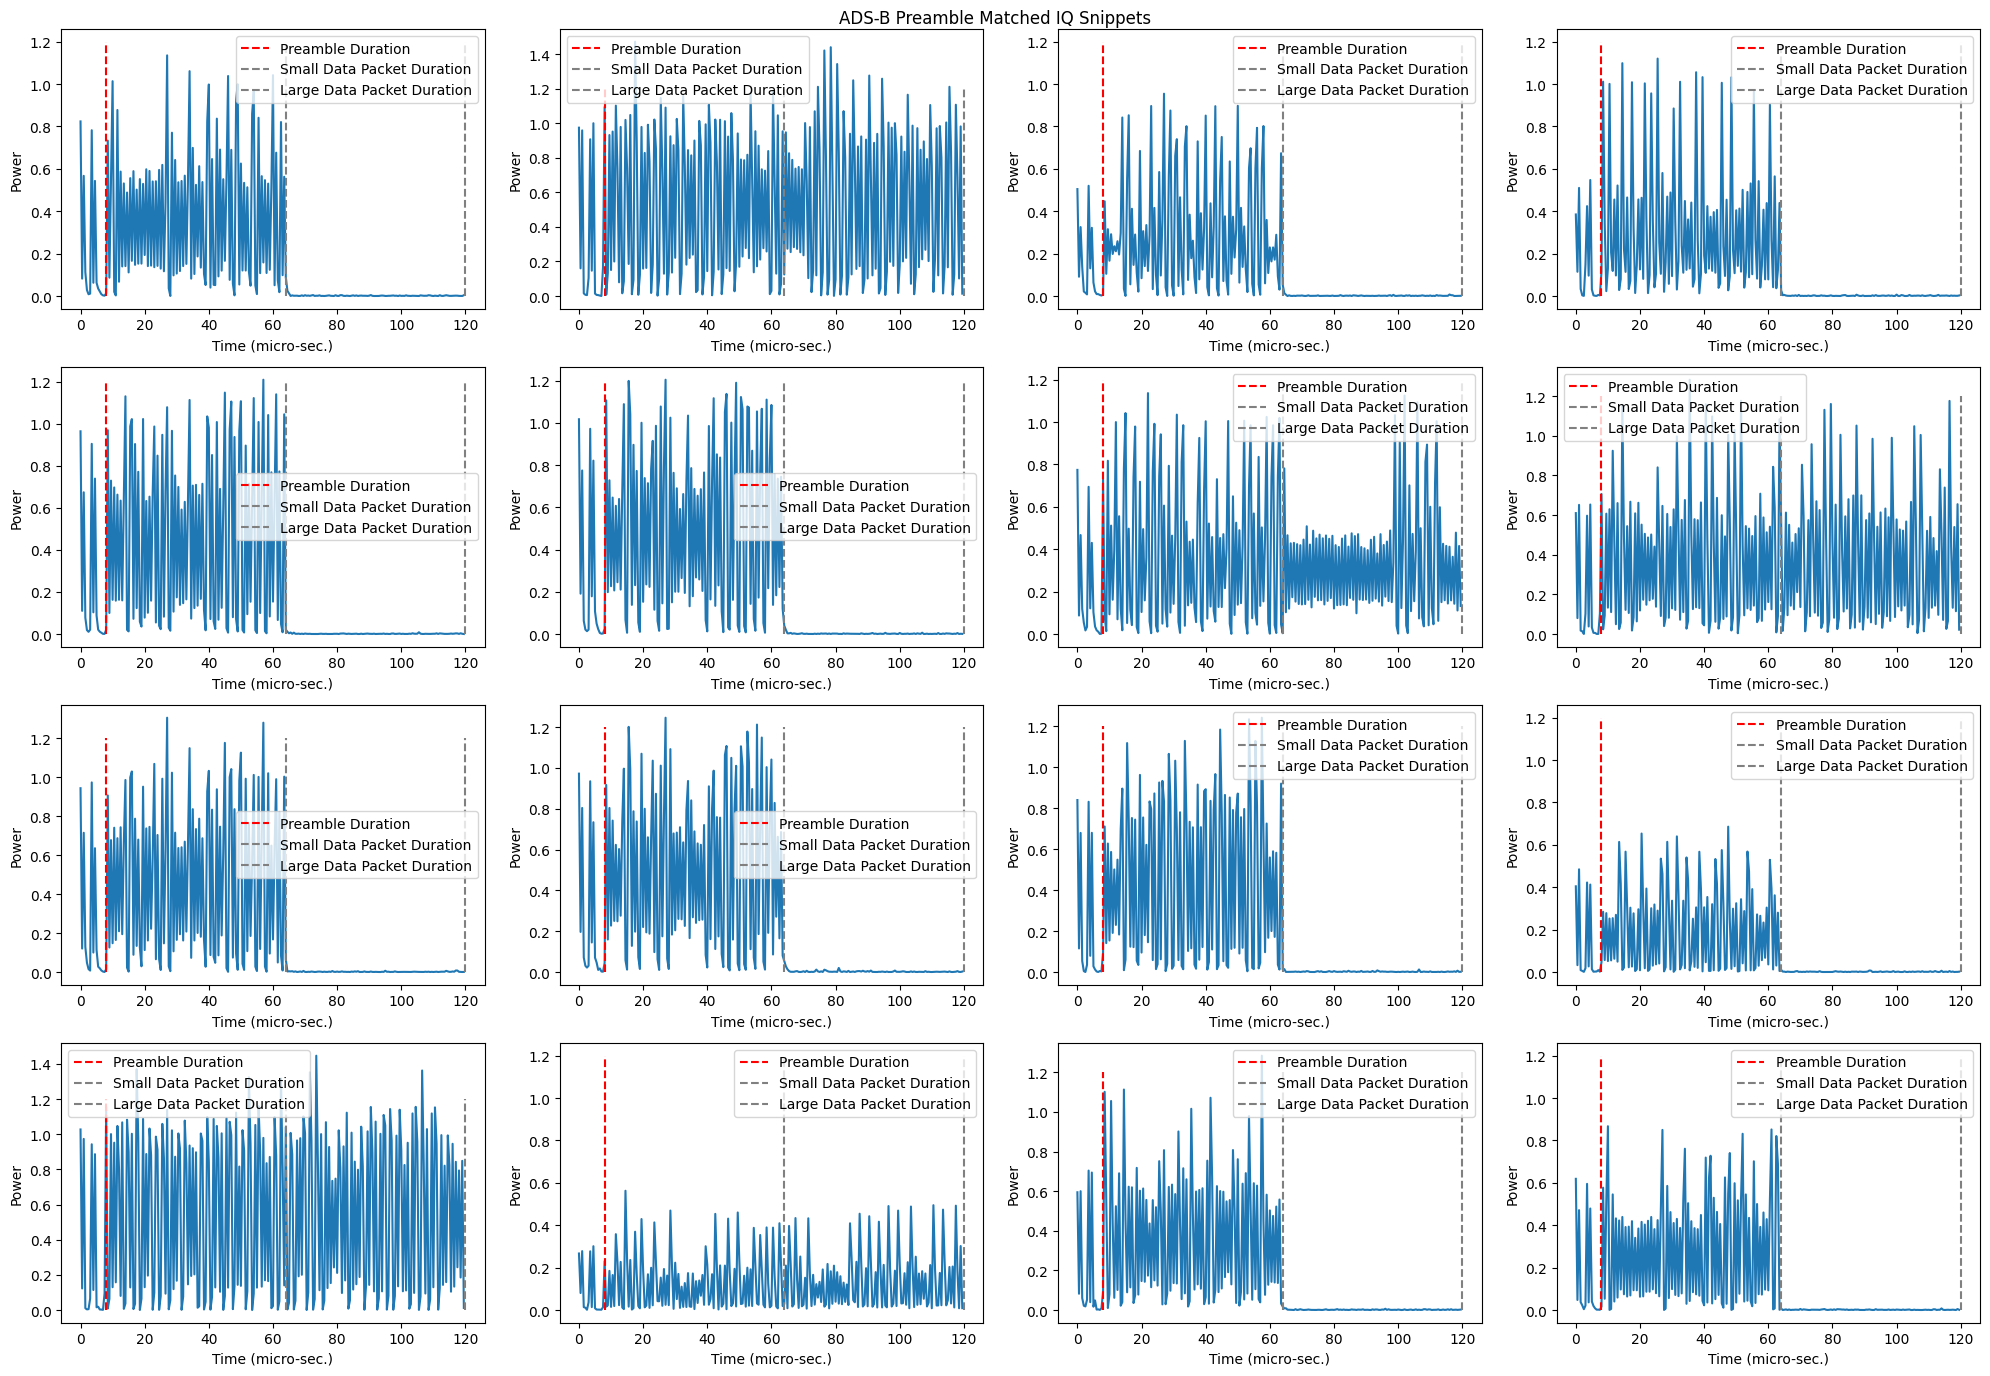

In [17]:
num_samples_to_plot: int = 16
num_rows = num_cols = int(num_samples_to_plot**0.5)

fig, axes = plt.subplots(num_rows, num_cols)
fig.set_size_inches(20.0, 14.0)
for ridx in range(num_rows):
    for cidx in range(num_cols):
        start_idx = packet_start_idxs[ridx + int(cidx * num_cols)]
        stop_idx = start_idx + preamble_num_samples + max_data_packet_num_samples
        time_sec = np.arange(
            0, preamble_num_samples + max_data_packet_num_samples
        ) / sample_rate_hz
        axes[ridx][cidx].plot(time_sec * 1e6, signal_power[start_idx:stop_idx])
        axes[ridx][cidx].vlines(
            x = 1e6 * preamble_num_samples/sample_rate_hz, 
            ymin = 0.0,
            ymax = 1.2,
            label = "Preamble Duration",
            color = "red",
            linestyle = "--"
        )
        axes[ridx][cidx].vlines(
            x = 1e6 * (preamble_num_samples + small_data_packet_num_samples)/sample_rate_hz, 
            ymin = 0.0,
            ymax = 1.2,
            label = "Small Data Packet Duration",
            color = "gray",
            linestyle = "--"
        )
        axes[ridx][cidx].vlines(
            x = 1e6 * (preamble_num_samples + large_data_packet_num_samples)/sample_rate_hz, 
            ymin = 0.0,
            ymax = 1.2,
            label = "Large Data Packet Duration",
            color = "gray",
            linestyle = "--"
        )
        axes[ridx][cidx].set_xlabel("Time (micro-sec.)")
        axes[ridx][cidx].set_ylabel("Power")
        axes[ridx][cidx].legend()
fig.suptitle("ADS-B Preamble Matched IQ Snippets")
fig.tight_layout()

Notice how some of the detected preamble signal have non-zero `signal_power`  
energy up to the `small_data_packet_duration` and others have non-zero energy  
up to the `large_data_packet_duration`.

We can now try to demodulate the remainder of each detected preamble packet and  
decode the message. After extracting the data packet's `adsb_bits`, we'll use an  
external _http_ call to decode the raw message data.

In [30]:
import requests

In [31]:
def demodulate_adsb_data(
    signal_power: np.ndarray, power_threshold: float
) -> np.ndarray:
    adsb_bits: list[int] = []
    for sample_idx in np.arange(0, signal_power.size, 2):
        # Given the start of the preamble of the signal sequence has been 
        # identified, the power threshold is used to detect if a transmission is 
        # present across at least one of the modulated bits. If the transmission
        # of the ADS-B packet stopped (e.g., end of a smaller data packet size), 
        # the adsb_bit demodulation is stopped and returned.
        first_bit_below_threshold = signal_power[sample_idx] < power_threshold
        second_bit_below_threshold = signal_power[sample_idx + 1] < power_threshold
        if first_bit_below_threshold and second_bit_below_threshold:
            break
        
        # To more robustly handle varying signal power, the modulated ADS-B PPM 
        # bits of [1,0] or [0,1] are compared in power rather than using a 
        # static threshold.
        if signal_power[sample_idx] > signal_power[sample_idx + 1]:
            adsb_bits.append(1)
        elif signal_power[sample_idx] < signal_power[sample_idx + 1]:
            adsb_bits.append(0)
        else:
            break
    
    return np.array(adsb_bits)


In [32]:
def failed_to_decode(msg: str) -> bool:
    if "Failed to decode." in msg: return True
    if "Decoding Failure." in msg: return True
    return False

In [36]:
power_threshold: float = 0.05

In [37]:
packet_errors: int = 0
decoded_packets: list[str] = []
for pidx, packet_start_idx in enumerate(packet_start_idxs):
    start_idx = packet_start_idx + preamble_num_samples
    stop_idx = start_idx + max_data_packet_num_samples
    adsb_bits = demodulate_adsb_data(
        signal_power[start_idx:stop_idx], power_threshold
    )
    
    if adsb_bits.size >= (large_data_packet_num_samples // 2):
       adsb_bits = adsb_bits[:large_data_packet_num_samples // 2]
    elif adsb_bits.size >= (small_data_packet_num_samples // 2):
       adsb_bits = adsb_bits[:small_data_packet_num_samples // 2]
    else:
        packet_errors += 1
        continue
    
    adsb_bits_hex = hex(int(''.join(map(str, adsb_bits)), 2)).replace('0x','')
    response = requests.get(f"http://jasonplayne.com:8080/decode?packet={adsb_bits_hex}&refLat=&refLon=")
    if failed_to_decode(response.text):
        packet_errors += 1
    else:
        decoded_packets.append(response.text)
    
print(f"Number of Packet Errors: [{packet_errors}/{len(packet_start_idxs)}]")

Number of Packet Errors: [102/160]
